<a href="https://colab.research.google.com/github/Pankajjoshi11/sentiment_analysis_tweets/blob/main/research_practise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.utils import resample


In [ ]:
def process_and_combine_datasets(bjp_file, congress_file):
    # Load and preprocess BJP dataset
    bjp_data = pd.read_csv(bjp_file)
    bjp_data = bjp_data.drop(columns=["Unnamed: 0"])  # Drop unnecessary columns
    bjp_data = bjp_data.drop_duplicates(subset=["tweet"])  # Remove duplicates
    bjp_data['tweet'] = bjp_data['tweet'].apply(preprocess_tweet)

    # Load and preprocess Congress dataset
    congress_data = pd.read_csv(congress_file)
    congress_data = congress_data.drop(columns=["Unnamed: 0"])  # Drop unnecessary columns
    congress_data = congress_data.drop_duplicates(subset=["tweet"])  # Remove duplicates
    congress_data['tweet'] = congress_data['tweet'].apply(preprocess_tweet)

    # Combine both datasets
    combined_data = pd.concat([bjp_data, congress_data])

    # Balance dataset
    positive = combined_data[combined_data['target'] == 1]
    negative = combined_data[combined_data['target'] == 0]
    if len(positive) < len(negative):
        positive = resample(positive, replace=True, n_samples=len(negative), random_state=42)
    else:
        negative = resample(negative, replace=True, n_samples=len(positive), random_state=42)
    balanced_data = pd.concat([positive, negative])

    return balanced_data


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Model with precision, recall, and F1 score calculation
def build_and_train_cnn_model(data):
    X = data['tweet']
    y = data['target']

    # Tokenization and padding
    tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
    tokenizer.fit_on_texts(X)
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=150, padding='post', truncating='post')

    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Building the model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=150),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Training with callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

    model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.1, callbacks=[early_stop,reduce_lr])

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Predictions and metrics
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return model


In [ ]:
import re
def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.lower()
    return tweet


In [ ]:
def main():
    # Process and combine datasets
    combined_data = process_and_combine_datasets('/content/bjp_tweets.csv', '/content/congress_tweets.csv')

    # Train CNN model and evaluate
    build_and_train_cnn_model(combined_data)

# Run the main function
if __name__ == "__main__":
    main()

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3446/3446 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.7616 - loss: 0.4815 - val_accuracy: 0.9288 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 2/30
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9528 - loss: 0.1398 - val_accuracy: 0.9252 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 3/30
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9761 - loss: 0.0662 - val_accuracy: 0.9396 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 4/30
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9824 - loss: 0.0529 - val_accuracy: 0.9438 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 5/30
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9892 - loss: 0.0378 - val_accuracy: 0.9399 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 6/30
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9902 - loss: 0.0327 - val_accuracy: 0.9468 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 7/30
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9923 - loss: 

In [ ]:
history = {
    "epoch": list(range(1, 31)),
    "accuracy": [0.7616, 0.9528, 0.9761, 0.9824, 0.9892, 0.9902, 0.9923, 0.9927, 0.9973, 0.9992, 0.9993, 0.9989, 0.9995, 0.9987, 0.9996, 0.9998, 0.9998, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
    "loss": [0.4815, 0.1398, 0.0662, 0.0529, 0.0378, 0.0327, 0.0283, 0.0258, 0.0098, 0.0035, 0.0020, 0.0056, 0.0026, 0.0071, 0.0014, 0.0008, 0.0007, 0.0002, 0.0000, 0.0004, 0.0000, 0.0000, 0.0001, 0.0004, 0.0000, 0.0000, 0.0000, 0.0002, 0.0000, 0.0000],
    "val_accuracy": [0.9288, 0.9252, 0.9396, 0.9438, 0.9399, 0.9468, 0.9487, 0.9497, 0.9510, 0.9559, 0.9278, 0.9455, 0.9412, 0.9367, 0.9484, 0.9487, 0.9465, 0.9491, 0.9468, 0.9504, 0.9461, 0.9468, 0.9458, 0.9478, 0.9448, 0.9484, 0.9507, 0.9452, 0.9481, 0.9478],
    "val_loss": [0.2038, 0.2100, 0.1916, 0.2445, 0.2362, 0.2803, 0.2584, 0.2784, 0.4001, 0.4044, 0.7706, 0.5350, 0.9579, 0.5910, 0.6244, 0.7547, 0.8750, 0.7953, 0.8458, 0.8978, 0.9675, 1.0146, 1.1225, 1.0415, 1.1651, 1.0777, 1.0699, 1.1700, 1.1220, 1.1527],
    "learning_rate": [0.0010] * 8 + [0.0005] * 6 + [0.00025] * 5 + [0.000125] * 6 + [0.0000625] * 5
}


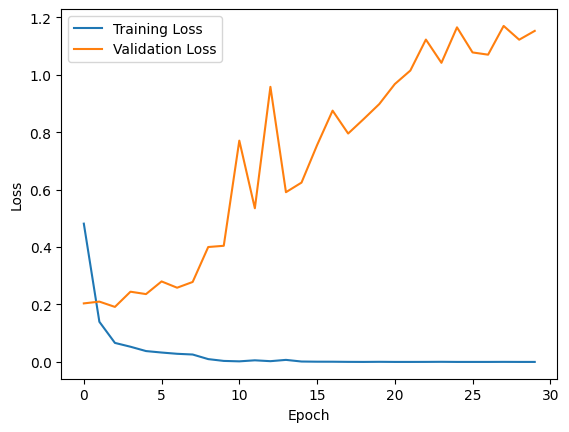

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['loss'],label='Training Loss')
plt.plot(history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

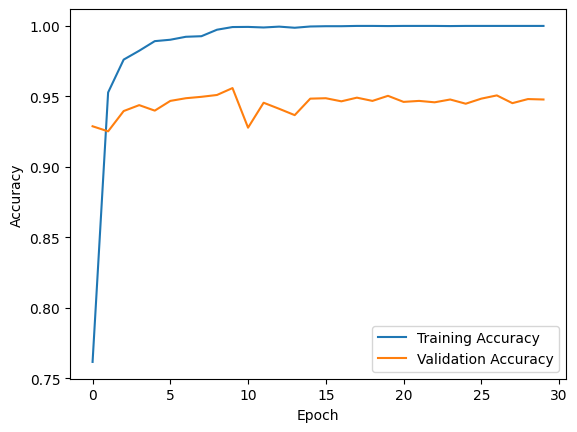

In [ ]:
plt.plot(history['accuracy'],label='Training Accuracy')
plt.plot(history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()